## Generate charts to use in model

In [262]:
# required packages
import fxcmpy
import socketio
import quandl
import fxcmconfig as cfgs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import IPython.display as IPydisplay
from PIL import Image


In [81]:
# create connection to fxcm / get data / store data to re-use in future 
con = fxcmpy.fxcmpy(access_token = cfgs.FXCM['access_token']
                    , log_level = cfgs.FXCM['log_level']
                    , server='demo'
                    , log_file=cfgs.FXCM['log_file'])

# get data and store
eur_jpy_data = con.get_candles('EUR/JPY'
                               , period='m15'
                               , start = '2020-04-04'
                               , end = '2020-11-01'
                               , with_index=False)

eur_jpy_data.to_csv('eur_jpy_m15_20200404_20201101.csv'
                    , index = False)

In [116]:
# load data and examine
eur_jpy_data = pd.read_csv('eur_jpy_m15_20200404_20201101.csv')

eur_jpy_data.head()

,date,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty
0,2020-04-05 21:00:00,117.178,117.167,117.175,117.123,117.276,117.254,117.272,117.202,30
1,2020-04-05 21:15:00,117.167,117.142,117.185,117.125,117.254,117.203,117.282,117.203,22
2,2020-04-05 21:30:00,117.142,117.251,117.268,117.210,117.203,117.354,117.369,117.308,32
3,2020-04-05 21:45:00,117.251,117.195,117.271,117.180,117.354,117.298,117.372,117.274,51
4,2020-04-05 22:00:00,117.195,117.379,117.417,117.107,117.298,117.410,117.452,117.186,4570


In [117]:
# create a single `open', `close', `high', `low' metrics with bid/ask prices 
eur_jpy_data.loc[:,'open'] = (eur_jpy_data.bidopen + eur_jpy_data.askopen)/2 
eur_jpy_data.loc[:,'close'] = (eur_jpy_data.bidclose + eur_jpy_data.askclose)/2 
eur_jpy_data.loc[:,'high'] = (eur_jpy_data.bidhigh + eur_jpy_data.askhigh)/2 
eur_jpy_data.loc[:,'low'] = (eur_jpy_data.bidlow + eur_jpy_data.asklow)/2 
#eur_jpy_data.loc[:,'avg_price'] = (eur_jpy_data.open + eur_jpy_data.close)/2 

# reformat date to date-time
eur_jpy_data.date = pd.to_datetime(eur_jpy_data.date)

In [118]:
# filter out only the required metrics / structure the dataframe
eur_jpy_data = eur_jpy_data.loc[:,['date','open','close','high','low','tickqty'
                                  # ,'avg_price'
                                  ]]
eur_jpy_data.columns = ['date','open','close','high','low','volume'
                       # ,'avg_price'
                       ]

eur_jpy_data.set_index('date',inplace = True)
eur_jpy_data.sort_index(inplace=True)

In [128]:
# create basic moving-average indicators (50 EMA 200 EMA)
eur_jpy_data['ewm_50_m'] = eur_jpy_data['close'].ewm(span=50
                                                   , min_periods=0
                                                   , adjust=False
                                                   , ignore_na=False).mean()
eur_jpy_data['ewm_50_h'] = eur_jpy_data['high'].ewm(span=50
                                                   , min_periods=0
                                                   , adjust=False
                                                   , ignore_na=False).mean()
eur_jpy_data['ewm_50_l'] = eur_jpy_data['low'].ewm(span=50
                                                   , min_periods=0
                                                   , adjust=False
                                                   , ignore_na=False).mean()

eur_jpy_data['ewm_200'] = eur_jpy_data['close'].ewm(span=200
                                                   , min_periods=0
                                                   , adjust=False
                                                   , ignore_na=False).mean()


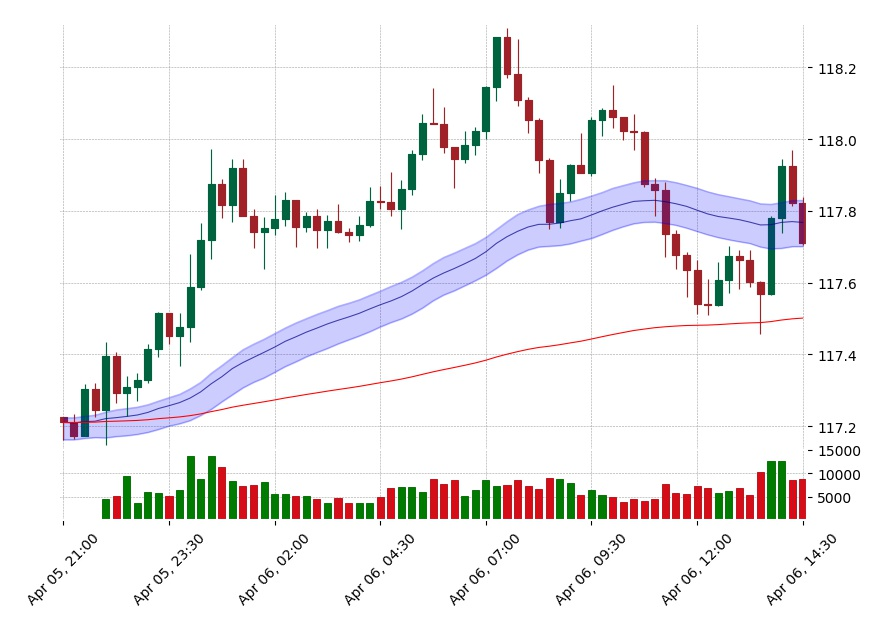

In [307]:
# generate a sample candle-stick image with indicators

temp_df = eur_jpy_data.iloc[:71,:]

#tcdf = temp_df[['ewm_50_h','ewm_50_l','ewm_50_m','ewm_200']]  # DataFrame with two columns
#apd  = mpf.make_addplot(tcdf)
#mpf.plot(df,addplot=apd)


apds = [mpf.make_addplot(temp_df['ewm_50_h']
                         #, linestyle ='dashdot'
                         , color = 'blue'
                         , alpha = 0.2),
        mpf.make_addplot(temp_df['ewm_50_m']
                         #, linestyle ='dashdot'
                         , color = 'darkblue'
                         , alpha = 0.7),
        mpf.make_addplot(temp_df['ewm_50_l']
                         #, linestyle ='dashdot'
                         , color = 'blue'
                         , alpha = 0.2),
        mpf.make_addplot(temp_df['ewm_200']
                         #, linestyle ='line'
                         , color='red')
       ]

s  = mpf.make_mpf_style(base_mpf_style='charles'
                        , gridstyle = 'dashed')

test = mpf.plot(temp_df
                  , type = 'candle'
                  , style = s
                  , volume = True
                  #, figscale=1
                  #, title='Apple, March - 2020'
                  , ylabel=''
                  , ylabel_lower=''
                  #, xrotation=90
                  #, figsize = (7,4)
                  , figratio = (12,8)
                  , tight_layout = True
                  , addplot = apds
                  , panel_ratios = (6,1)
                  #, show_nontrading = True
                  , fill_between = dict(y1 = temp_df['ewm_50_h'].values
                                        , y2 = temp_df['ewm_50_l'].values
                                        , alpha=0.2
                                        , color='b')
                  , scale_width_adjustment = dict(volume=0.7
                                                  , candle=1.2
                                                  , lines=0.3)
                  , savefig=dict(fname='chart.jpg'
                                 , dpi=100
                                 , pad_inches=0.25))

IPydisplay.Image(filename='chart.jpg')

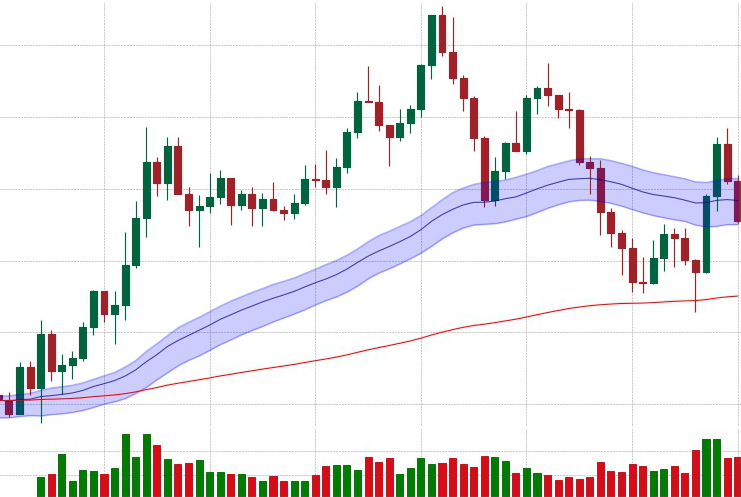

In [308]:
img = Image.open('chart.jpg')
w, h = img.size
img.crop((65, 22, w-80, h-113))

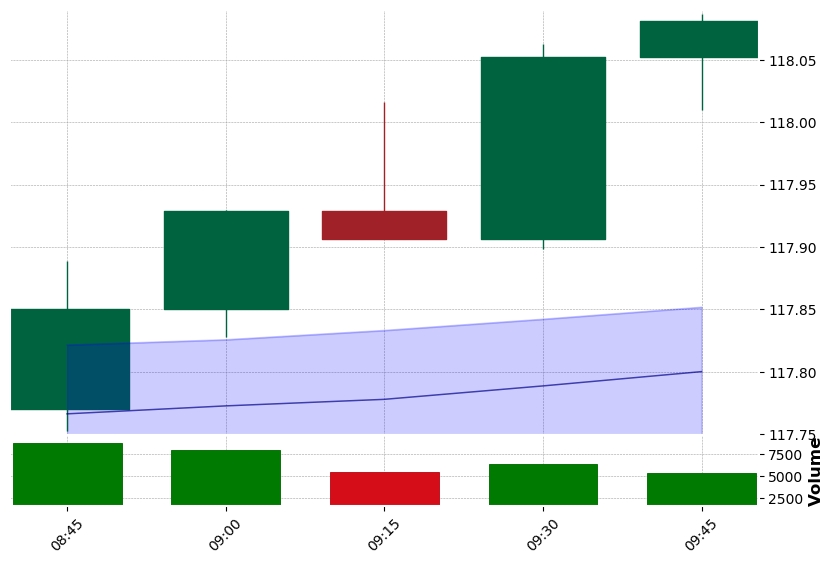

In [222]:
temp_df = eur_jpy_data.iloc[47:52,:]

#tcdf = temp_df[['ewm_50_h','ewm_50_l','ewm_50_m','ewm_200']]  # DataFrame with two columns
#apd  = mpf.make_addplot(tcdf)
#mpf.plot(df,addplot=apd)


apds = [mpf.make_addplot(temp_df['ewm_50_h']
                         #, linestyle ='dashdot'
                         , color = 'blue'
                         , alpha = 0.2),
        mpf.make_addplot(temp_df['ewm_50_m']
                         #, linestyle ='dashdot'
                         , color = 'darkblue'
                         , alpha = 0.7),
        mpf.make_addplot(temp_df['ewm_50_l']
                         #, linestyle ='dashdot'
                         , color = 'blue'
                         , alpha = 0.2),
        mpf.make_addplot(temp_df['ewm_200']
                         #, linestyle ='line'
                         , color='red')
       ]


mpf.plot(temp_df
          , type = 'candle'
          , style = 'charles'
          , volume = True
          #, figscale=1
          #, title='Apple, March - 2020'
          , ylabel=''
          #, figsize = (7,4)
          , figratio = (12,8)
          , tight_layout = True
          , addplot = apds
          , panel_ratios = (6,1)
          #, show_nontrading = True
          , fill_between = dict(y1 = temp_df['ewm_50_h'].values
                                , y2 = temp_df['ewm_50_l'].values
                                , alpha=0.2
                                , color='b')
          , scale_width_adjustment = dict(volume=0.7
                                          , candle=1.2
                                          , lines=0.3)
          )

In [219]:
eur_jpy_data.iloc[46:47,:]

,open,close,high,low,volume,ewm_50,ewm_200,ewm_50_m,ewm_50_h,ewm_50_l
date,,,,,,,,,,
2020-04-06 08:30:00,117.942,117.7705,117.947,117.75,9030,117.762838,117.422941,117.762838,117.818696,117.701912


In [220]:
eur_jpy_data.iloc[47:51,:]

,open,close,high,low,volume,ewm_50,ewm_200,ewm_50_m,ewm_50_h,ewm_50_l
date,,,,,,,,,,
2020-04-06 08:45:00,117.7705,117.8505,117.8890,117.7525,8731,117.766275,117.427195,117.766275,117.821453,117.703896
2020-04-06 09:00:00,117.8505,117.9290,117.9295,117.8280,7971,117.772657,117.432188,117.772657,117.825691,117.708763
2020-04-06 09:15:00,117.9290,117.9065,118.0160,117.9065,5490,117.777905,117.436908,117.777905,117.833154,117.716517
2020-04-06 09:30:00,117.9065,118.0525,118.0625,117.8985,6389,117.788674,117.443033,117.788674,117.842148,117.723654
